# Lecture 3: Transformers & LLM Fundamentals

## Fine-Tuning TinyLlama with TRL

**Learning Objectives:**
- Load and quantize a language model
- Prepare data using chat templates
- Fine-tune using LoRA (Low-Rank Adaptation)
- Evaluate and test the fine-tuned model


---

## 1. Setup


In [43]:
# Install required packages
!pip install -q transformers accelerate datasets trl peft bitsandbytes torch matplotlib

In [44]:
# Import libraries
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, BitsAndBytesConfig
from datasets import Dataset
from trl import SFTTrainer
from peft import LoraConfig, prepare_model_for_kbit_training
import matplotlib.pyplot as plt

---

## 2. Model Loading

### Why 4-bit Quantization?
- **Memory Efficiency**: Reduces model size by ~4x (1.1B → ~300MB)
- **Enables Training**: Fits in free Colab GPU memory
- **Trade-off**: Slight accuracy loss, but enables fine-tuning on consumer hardware


In [45]:
# Model configuration
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Use EOS token for padding
tokenizer.padding_side = "right"  # Pad on the right side

print(f"✓ Tokenizer loaded: {model_name}")
print(f"  Vocabulary size: {len(tokenizer)}")

✓ Tokenizer loaded: TinyLlama/TinyLlama-1.1B-Chat-v1.0
  Vocabulary size: 32000


In [46]:
# Configure 4-bit quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Use 4-bit quantization
    bnb_4bit_compute_dtype=torch.float16,  # Compute in float16
    bnb_4bit_use_double_quant=True,  # Double quantization for better accuracy
    bnb_4bit_quant_type="nf4"  # NormalFloat4 quantization
)

# Load model with quantization
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    device_map="auto"  # Automatically place model on available GPU
)

# Prepare model for training (required for quantized models)
model = prepare_model_for_kbit_training(model)

print(f"✓ Model loaded with 4-bit quantization")
print(f"  Parameters: ~1.1B (quantized to ~300MB)")

✓ Model loaded with 4-bit quantization
  Parameters: ~1.1B (quantized to ~300MB)


---

## 3. Data Preparation

### Chat Template Format
TinyLlama uses a specific chat format with special tokens:
- `<|user|>`: Marks user input
- `<|assistant|>`: Marks assistant response
- `<|endoftext|>`: Marks end of sequence (EOS token)


In [47]:
# Training dataset: Inspirational quotes
quotes = [
    "The only way to do great work is to love what you do. - Steve Jobs",
    "Innovation distinguishes between a leader and a follower. - Steve Jobs",
    "Life is what happens to you while you're busy making other plans. - John Lennon",
    "The future belongs to those who believe in the beauty of their dreams. - Eleanor Roosevelt",
    "It is during our darkest moments that we must focus to see the light. - Aristotle",
    "Success is not final, failure is not fatal: it is the courage to continue that counts. - Winston Churchill",
    "The only impossible journey is the one you never begin. - Tony Robbins",
    "In the middle of difficulty lies opportunity. - Albert Einstein",
    "The way to get started is to quit talking and begin doing. - Walt Disney",
    "Don't let yesterday take up too much of today. - Will Rogers",
    "You learn more from failure than from success. Don't let it stop you. Failure builds character. - Unknown",
    "If you are working on something exciting that you really care about, you don't have to be pushed. - Steve Jobs",
    "People who are crazy enough to think they can change the world, are the ones who do. - Rob Siltanen",
    "We may encounter many defeats but we must not be defeated. - Maya Angelou",
    "The only person you are destined to become is the person you decide to be. - Ralph Waldo Emerson",
    "Go confidently in the direction of your dreams. Live the life you have imagined. - Henry David Thoreau",
    "The two most important days in your life are the day you are born and the day you find out why. - Mark Twain",
    "Your limitation—it's only your imagination.",
    "Great things never come from comfort zones.",
    "Dream it. Wish it. Do it.",
    "Success doesn't just find you. You have to go out and get it.",
    "The harder you work for something, the greater you'll feel when you achieve it.",
    "Dream bigger. Do bigger.",
    "Don't stop when you're tired. Stop when you're done.",
    "Wake up with determination. Go to bed with satisfaction.",
    "Do something today that your future self will thank you for.",
    "Little things make big things happen.",
    "It's going to be hard, but hard does not mean impossible.",
    "Don't wait for opportunity. Create it.",
    "Sometimes we're tested not to show our weaknesses, but to discover our strengths.",
    "The key to success is to focus on goals, not obstacles.",
    "Dream it. Believe it. Build it.",
    "If opportunity doesn't knock, build a door.",
    "The future depends on what you do today.",
    "Don't let your dreams be dreams.",
    "Work hard in silence, let your success be the noise.",
    "If you can dream it, you can do it.",
    "The only way to do great work is to love what you do.",
    "Don't be pushed around by the fears in your mind. Be led by the dreams in your heart.",
    "Do what you can, with what you have, where you are.",
    "Dreams don't work unless you do.",
    "Make it happen. Shock everyone.",
    "The way to get started is to quit talking and begin doing.",
    "Innovation distinguishes between a leader and a follower.",
    "The only impossible journey is the one you never begin.",
    "In the middle of difficulty lies opportunity.",
    "The future belongs to those who believe in the beauty of their dreams.",
    "It is during our darkest moments that we must focus to see the light.",
    "Success is not final, failure is not fatal: it is the courage to continue that counts.",
    "The only way to do great work is to love what you do.",
    "Life is what happens to you while you're busy making other plans.",
    "Don't let yesterday take up too much of today."
]

print(f"✓ Loaded {len(quotes)} inspirational quotes")

✓ Loaded 52 inspirational quotes


### Before vs. After: Chat Template Formatting

**Before (Raw Quote):**
```
The only way to do great work is to love what you do. - Steve Jobs
```

**After (Formatted for Training):**
```
<|user|>
Generate an inspirational quote.
<|assistant|>
The only way to do great work is to love what you do. - Steve Jobs<|endoftext|>
```

**Why?** The model learns to recognize the pattern: user asks → assistant responds.


In [48]:
# Format quotes using chat template
def format_quote(quote):
    """Convert raw quote to chat format"""
    return f"<|user|>\nGenerate an inspirational quote.\n<|assistant|>\n{quote}<|endoftext|>"

# Apply formatting to all quotes
formatted_quotes = [format_quote(quote) for quote in quotes]

# Create HuggingFace Dataset
dataset = Dataset.from_dict({"text": formatted_quotes})

print(f"✓ Dataset created: {len(dataset)} examples")
print(f"\nExample formatted text:")
print(formatted_quotes[0])

✓ Dataset created: 52 examples

Example formatted text:
<|user|>
Generate an inspirational quote.
<|assistant|>
The only way to do great work is to love what you do. - Steve Jobs<|endoftext|>


---

## 4. Configuration

### Hyperparameters Explained
- **Learning Rate**: How fast the model learns (too high = unstable, too low = slow)
- **Batch Size**: Number of examples processed together
- **Epochs**: How many times the model sees the entire dataset
- **Gradient Accumulation**: Simulates larger batch size (effective batch = batch_size × accumulation_steps)


In [49]:
# Hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
NUM_EPOCHS = 10
GRADIENT_ACCUMULATION_STEPS = 4
MAX_SEQ_LENGTH = 256

# Update tokenizer max length
tokenizer.model_max_length = MAX_SEQ_LENGTH

print("Training Configuration:")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Effective Batch Size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Max Sequence Length: {MAX_SEQ_LENGTH}")

Training Configuration:
  Learning Rate: 0.0001
  Batch Size: 4
  Effective Batch Size: 16
  Epochs: 10
  Max Sequence Length: 256


---

## 5. Training (SFT)

### Key Concepts

**SFT (Supervised Fine-Tuning)**:
- Model learns from input-output pairs
- Adjusts weights to match the training examples

**LoRA (Low-Rank Adaptation)**:
- Instead of updating all 1.1B parameters, we train small "adapter" matrices
- **Why?** Memory efficient, faster training, prevents catastrophic forgetting
- Only ~0.1% of parameters are trainable (the LoRA adapters)


In [50]:
# Configure LoRA (Low-Rank Adaptation)
peft_config = LoraConfig(
    r=64,  # Rank: lower rank = fewer parameters, less memory
    lora_alpha=16,  # Scaling factor for LoRA weights
    lora_dropout=0.1,  # Dropout to prevent overfitting
    bias="none",  # Don't train bias parameters
    task_type="CAUSAL_LM",  # Causal language modeling task
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]  # Which layers to adapt
)

print("✓ LoRA Configuration:")
print(f"  Rank (r): {peft_config.r}")
print(f"  Alpha: {peft_config.lora_alpha}")
print(f"  Target Modules: {len(peft_config.target_modules)} layers")

✓ LoRA Configuration:
  Rank (r): 64
  Alpha: 16
  Target Modules: 7 layers


In [51]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",  # Where to save checkpoints
    num_train_epochs=NUM_EPOCHS,  # Number of training epochs
    per_device_train_batch_size=BATCH_SIZE,  # Batch size per GPU
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,  # Accumulate gradients
    learning_rate=LEARNING_RATE,  # Learning rate
    lr_scheduler_type="cosine",  # Learning rate schedule
    warmup_steps=10,  # Warmup steps at the start
    logging_steps=5,  # Log loss every 5 steps
    save_steps=50,  # Save checkpoint every 50 steps
    save_total_limit=2,  # Keep only last 2 checkpoints
    optim="paged_adamw_8bit",  # Memory-efficient optimizer
    fp16=False,  # Disable mixed precision for quantized models
    report_to="none",  # Don't log to external services
)

print("✓ Training arguments configured")

✓ Training arguments configured


In [52]:
# Create SFT Trainer
trainer = SFTTrainer(
    model=model,  # The quantized model
    args=training_args,  # Training configuration
    train_dataset=dataset,  # Training data
    processing_class=tokenizer,  # Tokenizer for processing
    peft_config=peft_config,  # LoRA configuration
)

print("✓ SFT Trainer created")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Adding EOS to train dataset:   0%|          | 0/52 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/52 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/52 [00:00<?, ? examples/s]

✓ SFT Trainer created
  Trainable parameters: 50,462,720
  Total parameters: 666,068,992


In [53]:
# Start training
print("🚀 Starting training...")
print(f"Training for {NUM_EPOCHS} epochs")
print("-" * 50)

trainer.train()

print("-" * 50)
print("✅ Training completed!")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


🚀 Starting training...
Training for 10 epochs
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
5,2.699400
10,1.950800
15,1.083800
20,0.617200
25,0.493000
30,0.380500
35,0.439100
40,0.452600


--------------------------------------------------
✅ Training completed!


---

## 6. Visualization

### Understanding the Loss Curve
- **Decreasing loss** = Model is learning
- **Smooth curve** = Stable training
- **Noisy curve** = May need lower learning rate


In [54]:
# Extract training logs
training_logs = trainer.state.log_history
train_logs = [log for log in training_logs if 'loss' in log and 'eval_loss' not in log]

# Extract steps and losses
steps = [log['step'] for log in train_logs]
losses = [log['loss'] for log in train_logs]

print(f"Training Steps: {len(steps)}")
print(f"Initial Loss: {losses[0]:.4f}")
print(f"Final Loss: {losses[-1]:.4f}")
print(f"Loss Reduction: {((losses[0] - losses[-1]) / losses[0] * 100):.1f}%")

Training Steps: 8
Initial Loss: 2.6994
Final Loss: 0.4526
Loss Reduction: 83.2%


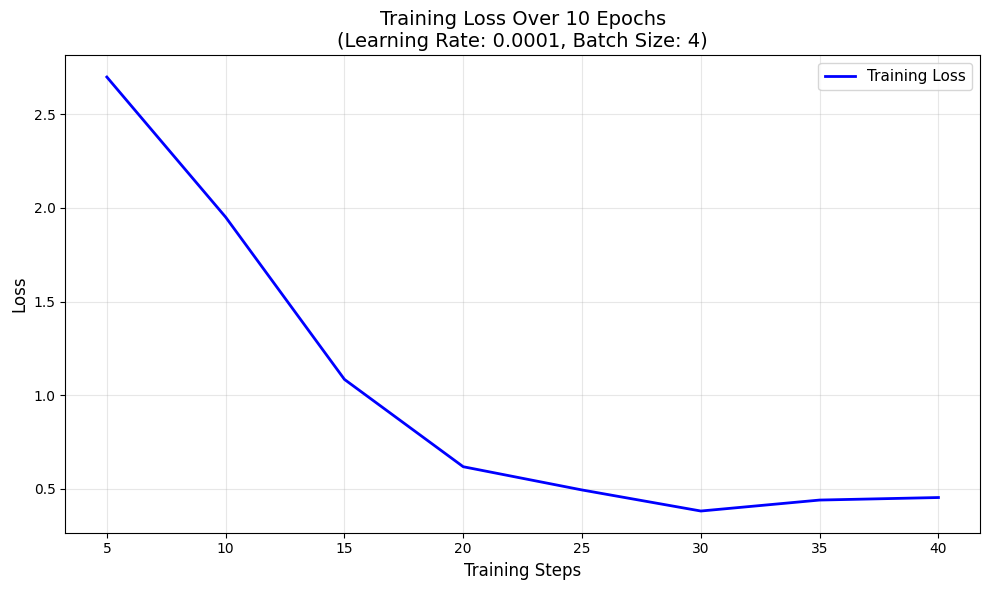

In [55]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, 'b-', linewidth=2, label='Training Loss')
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title(f'Training Loss Over {NUM_EPOCHS} Epochs\n(Learning Rate: {LEARNING_RATE}, Batch Size: {BATCH_SIZE})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

---

## 7. Inference

### Testing the Fine-Tuned Model
Now let's see if the model learned to generate inspirational quotes!


In [56]:
# Set model to evaluation mode
model.eval()

# Prepare the prompt (same format as training)
test_prompt = "<|user|>\nGenerate an inspirational quote.\n<|assistant|>\n"
# Explicitly create attention_mask to avoid warnings when pad_token == eos_token
inputs = tokenizer(test_prompt, return_tensors="pt", return_attention_mask=True).to(model.device)

print("📝 Prompt:")
print(test_prompt)
print("\n🤖 Generating quote...\n")

📝 Prompt:
<|user|>
Generate an inspirational quote.
<|assistant|>


🤖 Generating quote...



In [57]:
# Generate response
with torch.no_grad():
    outputs = model.generate(
        inputs.input_ids,
        attention_mask=inputs.attention_mask,  # Explicitly pass attention mask to avoid warnings
        max_new_tokens=150,  # Maximum length of generated text
        temperature=0.8,  # Controls randomness (lower = more deterministic)
        top_p=0.9,  # Nucleus sampling: consider top 90% of probability mass
        do_sample=True,  # Enable sampling (not greedy decoding)
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        repetition_penalty=1.1,  # Penalize repetition
    )

# Decode the output
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=False)

# Extract the quote (everything after <|assistant|>)
if "<|assistant|>" in generated_text:
    quote = generated_text.split("<|assistant|>")[1]
    # Remove end tokens
    for end_token in ["<|endoftext|>", "</s>"]:
        quote = quote.replace(end_token, "")
    quote = quote.strip()

    print("=" * 60)
    print("✨ Generated Quote:")
    print("=" * 60)
    print(quote)
    print("=" * 60)
else:
    print("⚠️ Could not extract quote from model output")


✨ Generated Quote:
Success is not final, failure is not fatal: it is the courage to continue that counts.


---

## 8. Assignment

### Task: Experiment with Hyperparameters

**Objective**: Understand how hyperparameters affect training.

**Instructions**:
1. Run the notebook once with default hyperparameters (already done above)
2. Modify the hyperparameters in Section 4 and **re-run the notebooek** by clicking `RUN ALL` from the Task Bar.
3. Compare the results

**Experiments to Try**:
- Try `LEARNING_RATE` = `5e-5`, `1e-4`, `5e-4`
- Try `NUM_EPOCHS` = `3`, `5`, `10`
- Try `BATCH_SIZE` = `4`, `8`
- You can experiment with your own combinations of the hyperparameters.

**What to Observe**:
- How does the loss curve change?
- Is training more stable or noisy?
- Does the model generate better quotes?

**Report**: Create a brief comparison (2-3 paragraphs) summarizing your findings.


---

## Key Takeaways

**What we learned:**
- ✅ How to quantize models for memory efficiency
- ✅ How to format data using chat templates
- ✅ How LoRA enables efficient fine-tuning
- ✅ How to train and evaluate a fine-tuned model

**Next Steps:**
- Experiment with different hyperparameters
- Try fine-tuning on your own dataset
- Explore other PEFT methods (IA³, AdaLoRA, etc.)
